In [1]:
## import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import keras 
import pickle
import joblib

from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

## neural network library
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Input
from mlxtend.plotting import plot_confusion_matrix

# scaling and pre processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler

# training and testing data split
from sklearn.model_selection import train_test_split


In [2]:
dataset = pd.read_csv("diabetes.csv")
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Glucose, blood pressure, skin thickness, insulin and BMI should not be zero, so we need to replace

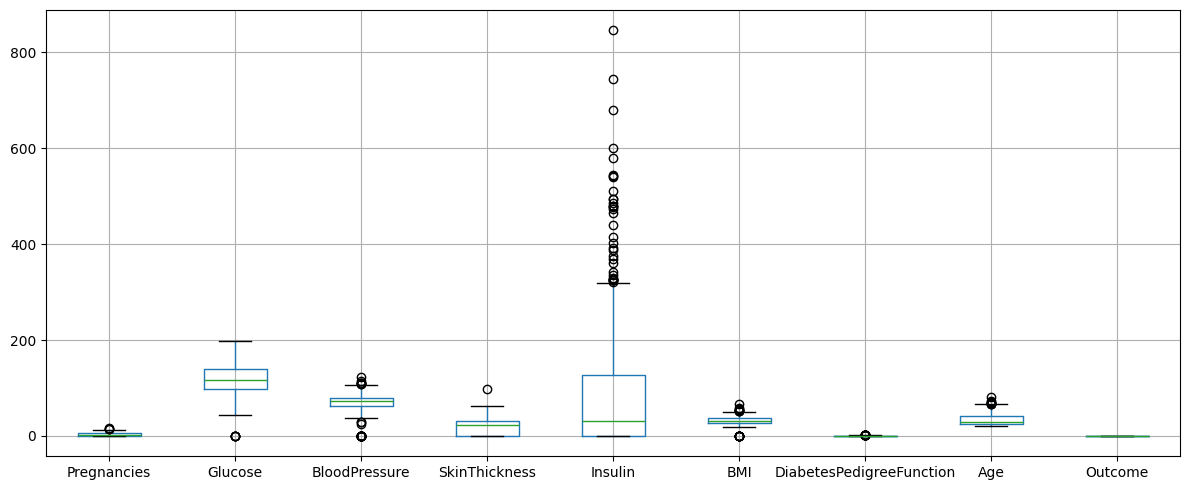

In [5]:
dataset.boxplot(figsize=(12,5))
plt.tight_layout()

filename = 'boxplot-raw.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

Huge outliers for Insulin

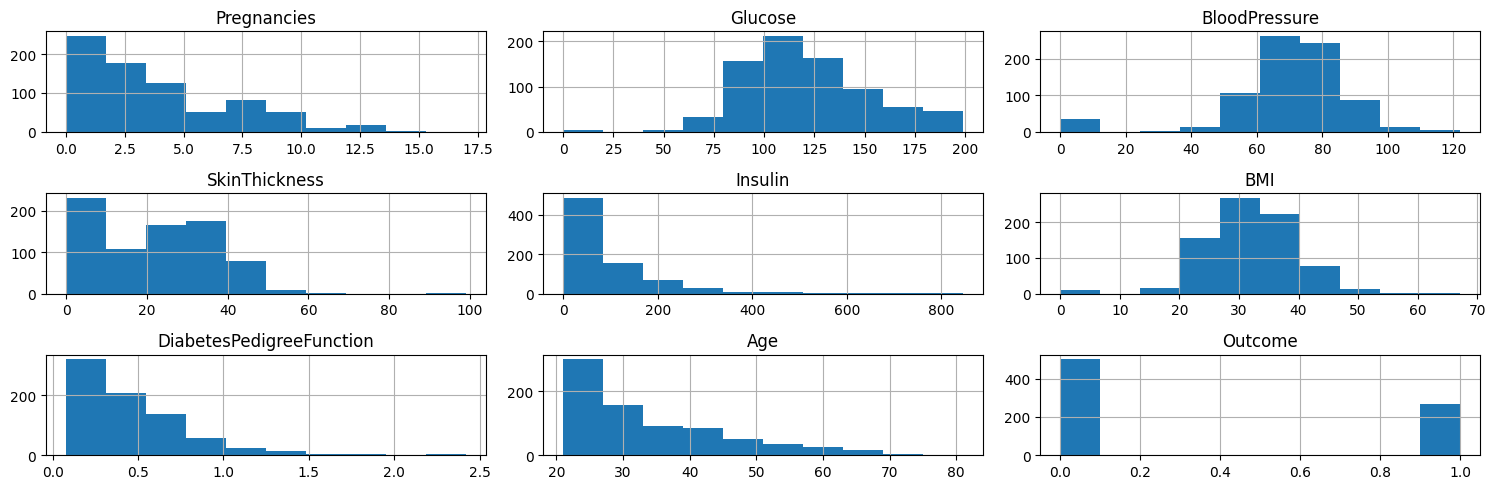

In [6]:
dataset.hist(bins = 10,figsize=(15,5))
plt.tight_layout()

filename = 'histograms-raw.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()


Glucose and blood pressure have a normal distribution with few outliers so they can be replaced with the mean

In [7]:
# replace dodgy zeroes with nans
replaceables = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
dataset[replaceables] = dataset[replaceables].replace(0,np.nan)
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [9]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Given we know the outcomes of diabetic and non-diabetic, we take the means of the glucose, blood pressure, skin thickness, insulin and 
# BMIs of each group to replace null values of each group, rather than using the same mean/median for both outcomes, which confuses the results

nullfactors = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

diabetics = dataset[(dataset['Outcome'] == 1)]
nondiabetics = dataset[(dataset['Outcome'] == 0)]

diabetics_by_glucose = diabetics['Glucose'].sum() / diabetics['Glucose'].count()
nondiabetics_by_glucose = nondiabetics['Glucose'].sum() / nondiabetics['Glucose'].count()

diabetics_by_bloodpressure = diabetics['BloodPressure'].sum() / diabetics['BloodPressure'].count()
nondiabetics_by_bloodpressure = nondiabetics['BloodPressure'].sum() / nondiabetics['BloodPressure'].count()

diabetics_by_skinthickness = diabetics['SkinThickness'].sum() / diabetics['SkinThickness'].count()
nondiabetics_by_skinthickness = nondiabetics['SkinThickness'].sum() / nondiabetics['SkinThickness'].count()

diabetics_by_insulin = diabetics['Insulin'].sum() / diabetics['Insulin'].count()
nondiabetics_by_insulin = nondiabetics['Insulin'].sum() / nondiabetics['Insulin'].count()

diabetics_by_bmi = diabetics['BMI'].sum() / diabetics['BMI'].count()
nondiabetics_by_bmi = nondiabetics['BMI'].sum() / nondiabetics['BMI'].count()

In [11]:
dataset['Glucose'] = np.where(dataset['Outcome'] == 1 & dataset['Glucose'].isnull(), diabetics_by_glucose, dataset['Glucose'])
dataset['Glucose'] = np.where(dataset['Outcome'] == 0 & dataset['Glucose'].isnull(), nondiabetics_by_glucose, dataset['Glucose'])

dataset['BloodPressure'] = np.where(dataset['Outcome'] == 1 & dataset['BloodPressure'].isnull(), diabetics_by_bloodpressure, dataset['BloodPressure'])
dataset['BloodPressure'] = np.where(dataset['Outcome'] == 0 & dataset['BloodPressure'].isnull(), nondiabetics_by_bloodpressure, dataset['BloodPressure'])

dataset['SkinThickness'] = np.where(dataset['Outcome'] == 1 & dataset['SkinThickness'].isnull(), diabetics_by_skinthickness, dataset['SkinThickness'])
dataset['SkinThickness'] = np.where(dataset['Outcome'] == 0 & dataset['SkinThickness'].isnull(), nondiabetics_by_skinthickness, dataset['SkinThickness'])

dataset['Insulin'] = np.where(dataset['Outcome'] == 1 & dataset['Insulin'].isnull(), diabetics_by_insulin, dataset['Insulin'])
dataset['Insulin'] = np.where(dataset['Outcome'] == 0 & dataset['Insulin'].isnull(), nondiabetics_by_insulin, dataset['Insulin'])

dataset['BMI'] = np.where(dataset['Outcome'] == 1 & dataset['BMI'].isnull(), diabetics_by_bmi, dataset['BMI'])
dataset['BMI'] = np.where(dataset['Outcome'] == 0 & dataset['BMI'].isnull(), nondiabetics_by_bmi, dataset['BMI'])


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [13]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.697358,72.428141,29.247042,157.003527,32.446420,0.471876,33.240885,0.348958
std,3.369578,23.042202,7.348551,5.696580,65.536069,4.452181,0.331329,11.760232,0.476951
min,0.000000,78.000000,30.000000,7.000000,14.000000,22.900000,0.078000,21.000000,0.000000
25%,1.000000,110.643863,70.877339,27.235457,130.287879,30.859674,0.243750,24.000000,0.000000
50%,3.000000,110.643863,70.877339,27.235457,130.287879,30.859674,0.372500,29.000000,0.000000
75%,6.000000,122.250000,70.877339,31.000000,184.250000,31.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,114.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

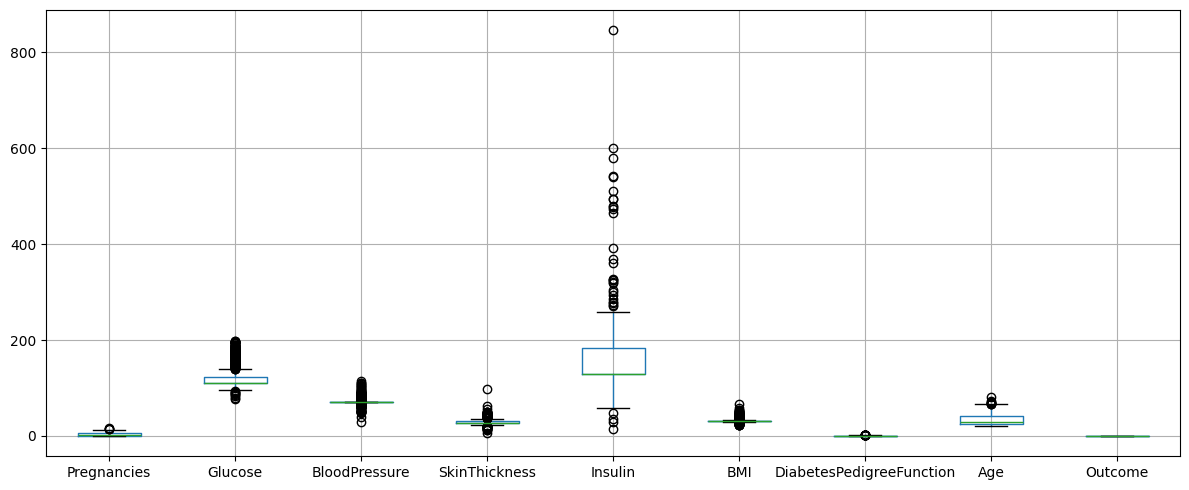

In [15]:
dataset.boxplot(figsize=(12,5))
plt.tight_layout()

filename = 'boxplot-preprocessed.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()


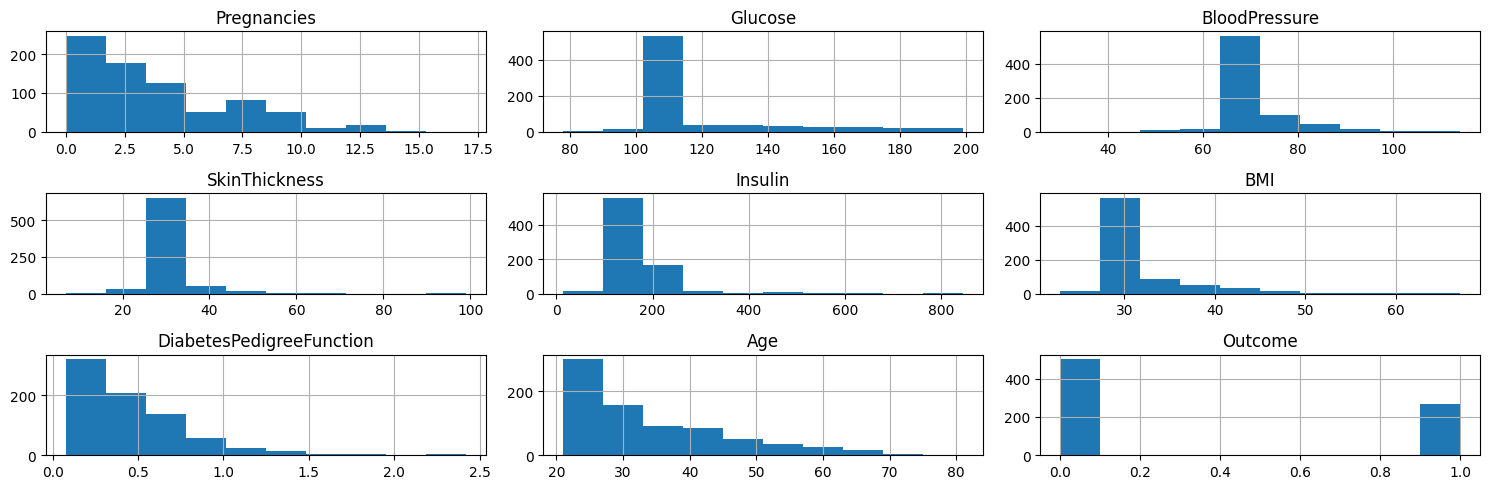

In [16]:
dataset.hist(bins = 10,figsize=(15,5))
plt.tight_layout()

filename = 'histograms-preprocessed.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

In [17]:
dataset['Outcome'].value_counts()


Outcome
0    500
1    268
Name: count, dtype: int64

0 = non diabetic
1 = diabetic

Unbalanced dataset with almost double the number of non-diabetic vs diabetic

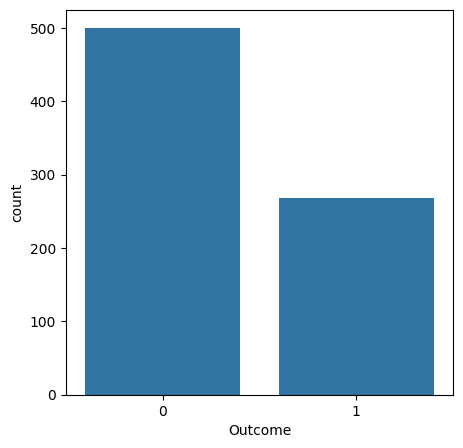

In [18]:
plt.figure(figsize=(5,5))
sns.countplot(x='Outcome',data=dataset)

filename = 'countplots-preprocessed.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()


Correlations

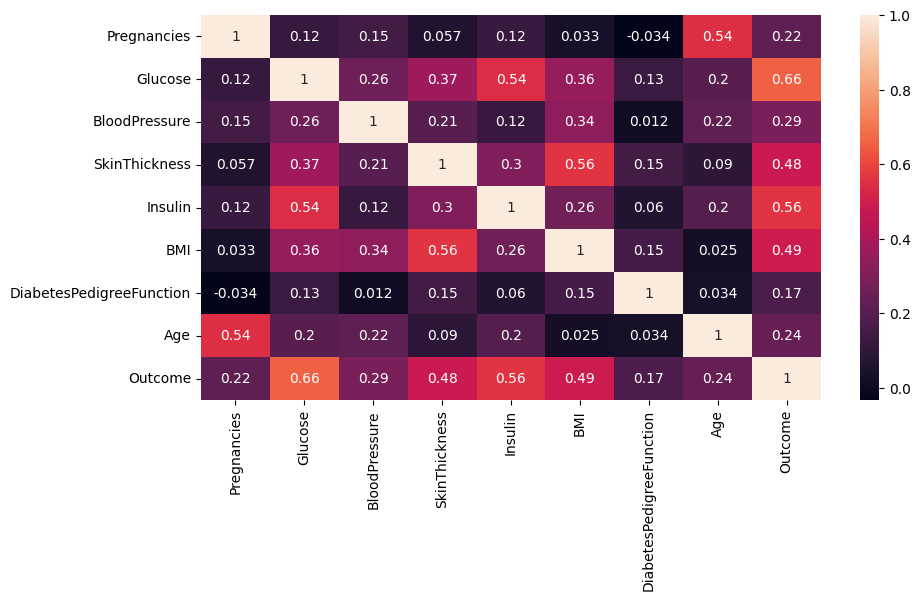

In [19]:
## visualize the correlation matrix
plt.figure(figsize=(10,5))
corrmatrix = dataset.corr()
sns.heatmap(corrmatrix, annot=True)

filename = 'corrmatrix-preprocessed.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

Every factor has a reasonable positive correlation with the outcome, especially Glucose and Insulin levels, and also BMI, SkinThickness and even Age, BloodPressure and Pregnancies, which would be expected.

Of course, we might have increased the correlation of glucose, insulin, bmi, bloodpressure and skinthickness with our choice of replacement values

In [20]:
corrmatrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.119273,0.148624,0.056563,0.122314,0.033237,-0.033523,0.544341,0.221898
Glucose,0.119273,1.000000,0.261062,0.371317,0.540850,0.356554,0.127658,0.203284,0.655656
BloodPressure,0.148624,0.261062,1.000000,0.205055,0.116494,0.340584,0.012283,0.216960,0.288440
SkinThickness,0.056563,0.371317,0.205055,1.000000,0.298800,0.557191,0.150030,0.089819,0.482642
Insulin,0.122314,0.540850,0.116494,0.298800,1.000000,0.261322,0.059716,0.200598,0.557168
BMI,0.033237,0.356554,0.340584,0.557191,0.261322,1.000000,0.152936,0.025228,0.487119
DiabetesPedigreeFunction,-0.033523,0.127658,0.012283,0.150030,0.059716,0.152936,1.000000,0.033561,0.173844
Age,0.544341,0.203284,0.216960,0.089819,0.200598,0.025228,0.033561,1.000000,0.238356
Outcome,0.221898,0.655656,0.288440,0.482642,0.557168,0.487119,0.173844,0.238356,1.000000


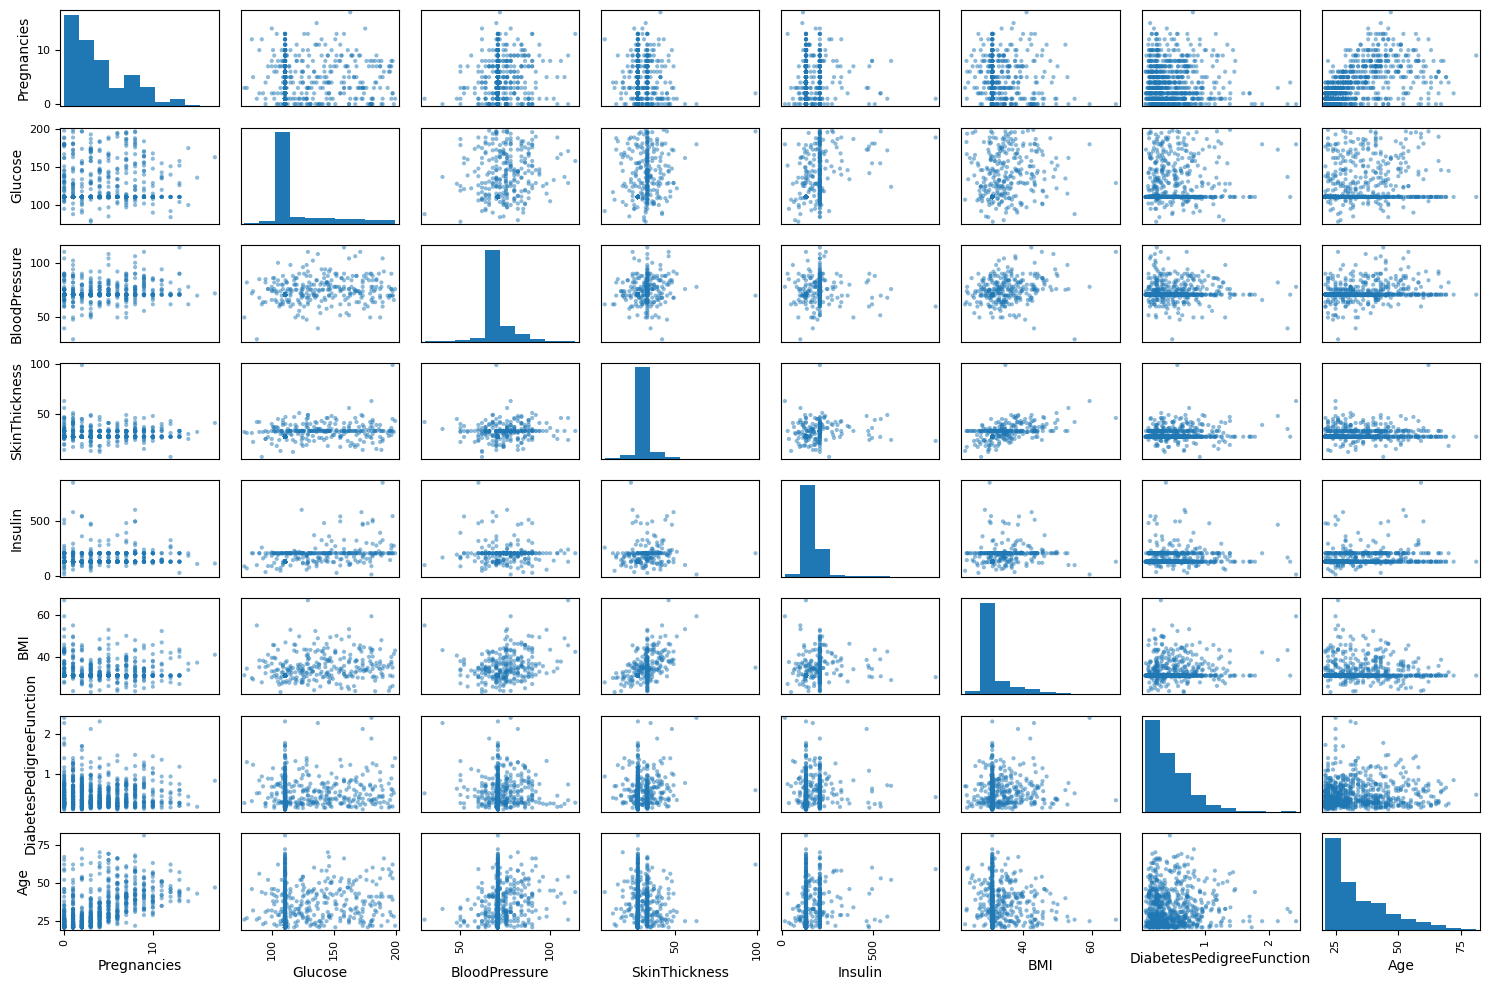

In [21]:
from pandas.plotting import scatter_matrix

riskfactors = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
scatter_matrix(dataset[riskfactors], figsize=(15,10))
plt.tight_layout()

filename = 'scattermatrices-raw.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

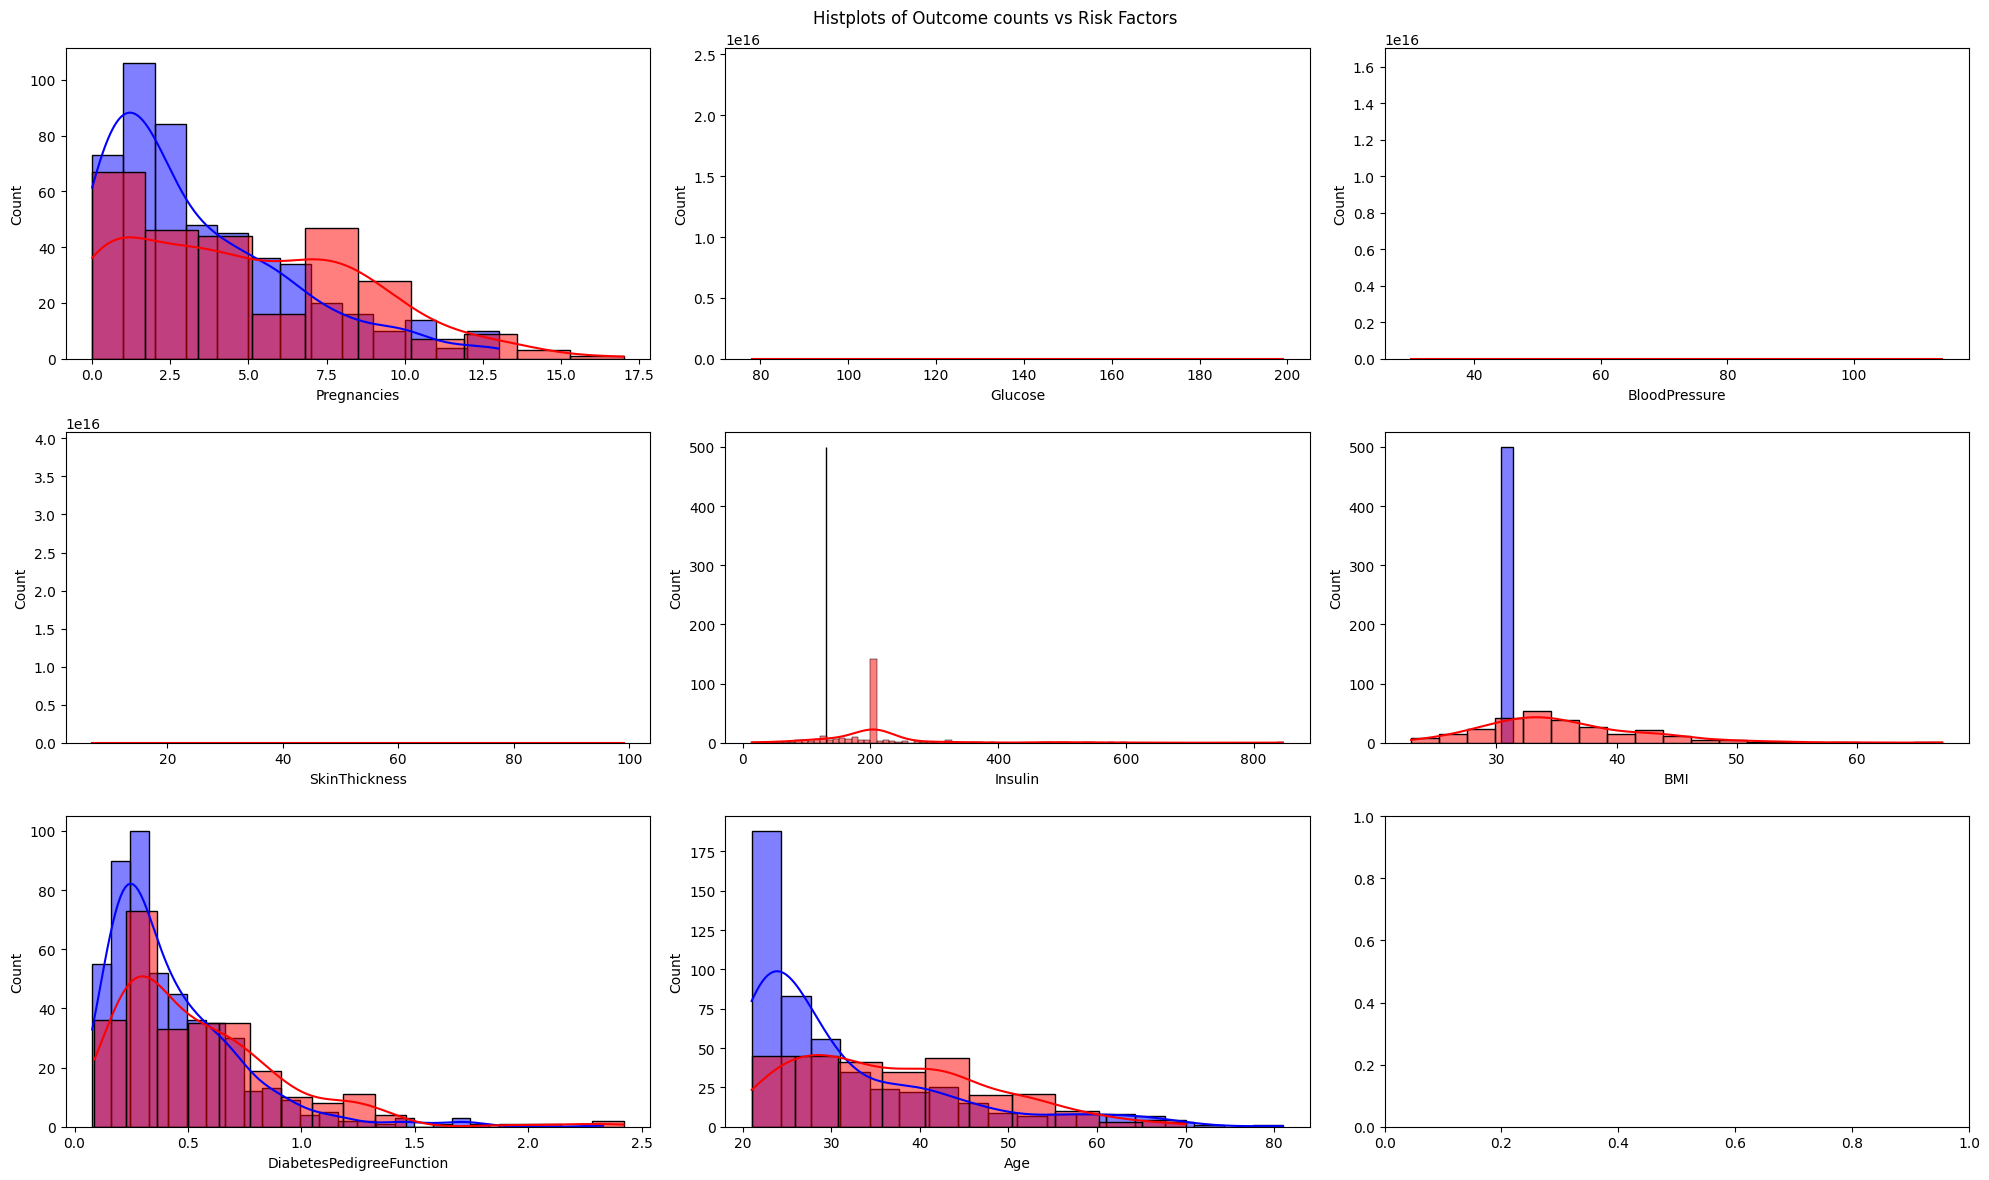

In [22]:
# Histplot with adjusted marker size and reduced overlap
fig, ax = plt.subplots(3, 3, figsize=(20, 12))  # Increased figure size for more room

riskfactors = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
riskindex = 0
row = 0

while row < 3:
    col = 0 
    while col < 3:
        if riskindex < len(riskfactors):
            sns.histplot(dataset[riskfactors[riskindex]][dataset.Outcome == 0], ax=ax[row, col],color="blue", kde=True), sns.histplot(dataset[riskfactors[riskindex]][dataset.Outcome == 1], ax=ax[row, col], color="red", kde=True)
            riskindex = riskindex + 1
        col = col + 1
    row = row + 1

plt.suptitle('Histplots of Outcome counts vs Risk Factors')
plt.tight_layout()  # Adjust layout for better spacing between subplots
filename = 'feature-outcome-histplots.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

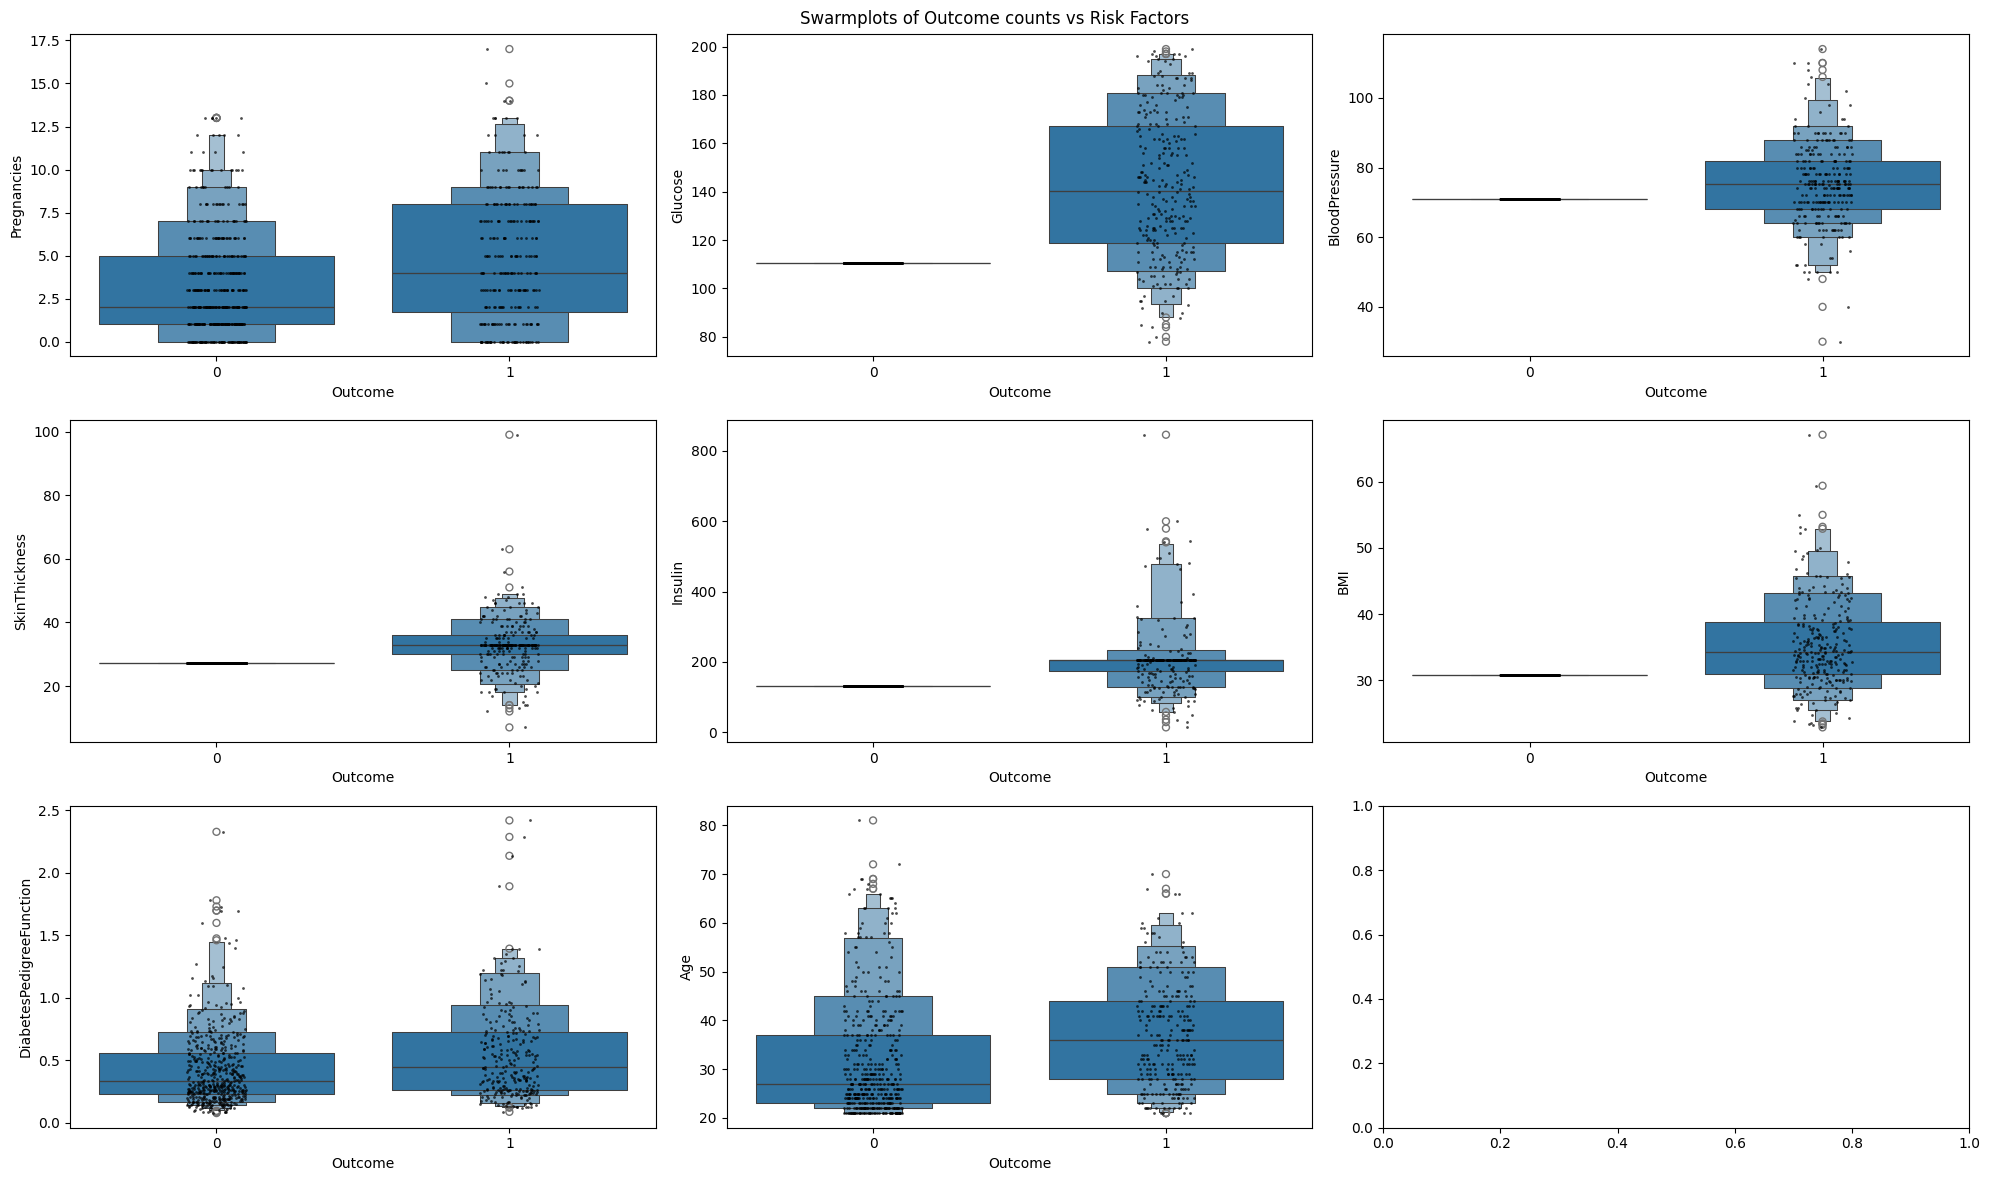

In [23]:
# Swarmplot with adjusted marker size and reduced overlap
fig, ax = plt.subplots(3, 3, figsize=(20, 12))  # Increased figure size for more room

riskindex = 0
row = 0

while row < 3:
    col = 0 
    while col < 3:
        if riskindex < len(riskfactors):
            sns.stripplot(ax=ax[row, col], x=dataset['Outcome'], y=dataset[riskfactors[riskindex]], color="black", alpha=0.7, size=2)  # Use stripplot and reduced size
            sns.boxenplot(ax=ax[row, col], x=dataset['Outcome'], y=dataset[riskfactors[riskindex]])
            riskindex = riskindex + 1
        col = col + 1
    row = row + 1

plt.suptitle('Swarmplots of Outcome counts vs Risk Factors')
plt.tight_layout()  # Adjust layout for better spacing between subplots
filename = 'feature-swarmplots.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

In [24]:
## defining independent and dependent variables
x=dataset.drop(["Outcome"],axis=1)
y=dataset["Outcome"]
x


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.000000,72.000000,35.000000,206.846154,33.600000,0.627,50
1,1,110.643863,70.877339,27.235457,130.287879,30.859674,0.351,31
2,8,183.000000,64.000000,33.000000,206.846154,23.300000,0.672,32
3,1,110.643863,70.877339,27.235457,130.287879,30.859674,0.167,21
4,0,137.000000,40.000000,35.000000,168.000000,43.100000,2.288,33
...,...,...,...,...,...,...,...,...
763,10,110.643863,70.877339,27.235457,130.287879,30.859674,0.171,63
764,2,110.643863,70.877339,27.235457,130.287879,30.859674,0.340,27
765,5,110.643863,70.877339,27.235457,130.287879,30.859674,0.245,30
766,1,126.000000,60.000000,33.000000,206.846154,30.100000,0.349,47


In [25]:
# Scaling

std_scaler = StandardScaler()
rbs_scaler = RobustScaler()
mms_scaler = MinMaxScaler()

# Fit and transform the data
std_scale_x = std_scaler.fit_transform(x)
rbs_scale_x = rbs_scaler.fit_transform(x)
mms_scale_x = mms_scaler.fit_transform(x)

# Save the scaler to a file using pickle - this ensures all users can use the same scaler
with open('std_scaler.pkl', 'wb') as f:
    pickle.dump(std_scaler, f)
with open('rbs_scaler.pkl', 'wb') as f:
    pickle.dump(rbs_scaler, f)
with open('mms_scaler.pkl', 'wb') as f:
    pickle.dump(mms_scaler, f)

print("Scalers saved")

Scalers saved


In [26]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [27]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.000000,72.000000,35.000000,206.846154,33.600000,0.627,50
1,1,110.643863,70.877339,27.235457,130.287879,30.859674,0.351,31
2,8,183.000000,64.000000,33.000000,206.846154,23.300000,0.672,32
3,1,110.643863,70.877339,27.235457,130.287879,30.859674,0.167,21
4,0,137.000000,40.000000,35.000000,168.000000,43.100000,2.288,33
...,...,...,...,...,...,...,...,...
763,10,110.643863,70.877339,27.235457,130.287879,30.859674,0.171,63
764,2,110.643863,70.877339,27.235457,130.287879,30.859674,0.340,27
765,5,110.643863,70.877339,27.235457,130.287879,30.859674,0.245,30
766,1,126.000000,60.000000,33.000000,206.846154,30.100000,0.349,47


In [ ]:
# train test split using each of the 3 scalers
x_train, x_test, y_train, y_test = train_test_split(std_scale_x,y,test_size=0.3, random_state=32)
#x_train, x_test, y_train, y_test = train_test_split(rbs_scale_x,y,test_size=0.3, random_state=32)
#x_train, x_test, y_train, y_test = train_test_split(mms_scale_x,y,test_size=0.3, random_state=32)

In [ ]:
## Neural Network
## initialise the NN
model = Sequential()

## set up the layers with best guesses
## input layer
model.add(Input(shape=(8,)))

##output layer
model.add(Dense(units= 1, kernel_initializer= 'uniform', activation = 'sigmoid'))

## compiling the ANN
## Here it's binary as people are diabetic or not
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])

## model
history = model.fit(x, y, batch_size = 25, epochs = 80, validation_split=0.25)

Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6569 - loss: 2.9089 - val_accuracy: 0.2031 - val_loss: 1.0388
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2529 - loss: 1.0655 - val_accuracy: 0.6771 - val_loss: 0.9456
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6940 - loss: 0.8497 - val_accuracy: 0.5625 - val_loss: 0.7925
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7322 - loss: 0.7283 - val_accuracy: 0.5469 - val_loss: 0.7121
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7340 - loss: 0.6710 - val_accuracy: 0.7344 - val_loss: 0.6402
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7772 - loss: 0.5942 - val_accuracy: 0.7760 - val_loss: 0.5872
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8066 - loss: 0.5691 - val_accuracy: 0.7708 - val_loss: 0.5616
Epoch 8/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8041 - loss: 0.5207 - val_accuracy: 0.8333 - val_

In [54]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 85.70%


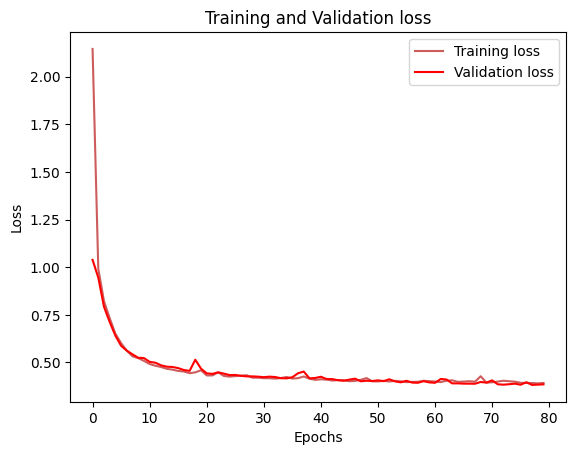

In [55]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

filename = 'Losses-per-epoch.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

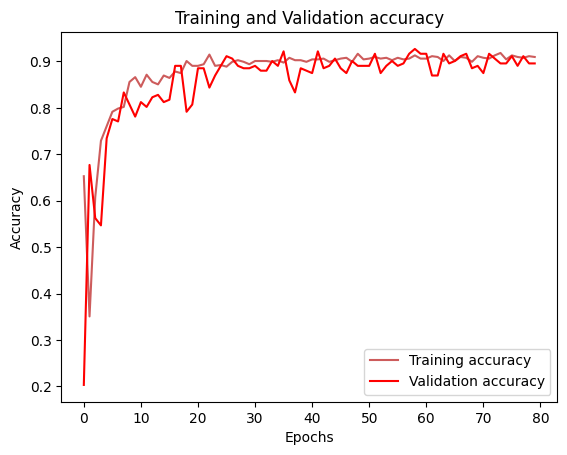

In [56]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

filename = 'Accuracy-per-epoch.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

In [57]:
# Predicting the test set results
y_pred = model.predict(x_test)
# set a threshold of 0.4
y_pred = np.where(y_pred > 0.4, 1, 0)
np.set_printoptions()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


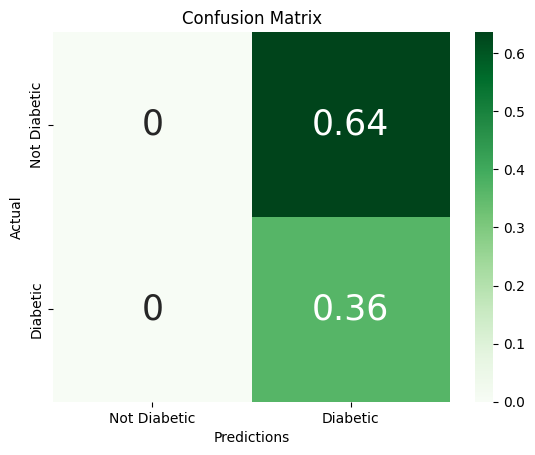

In [58]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Not Diabetic', 'Diabetic']
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, cmap='Greens',annot_kws = {'size':25}, xticklabels=labels, yticklabels=labels)
#sns.heatmap(cf_matrix, annot = True, cmap='Greens',annot_kws = {'size':25}, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

filename = 'ConfusionMatrix.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

Not great at predicting diabetes!

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.36      1.00      0.53        84

    accuracy                           0.36       231
   macro avg       0.18      0.50      0.27       231
weighted avg       0.13      0.36      0.19       231



c:\Users\G-Man\Installs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\G-Man\Installs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\G-Man\Installs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

AUC: 0.500000


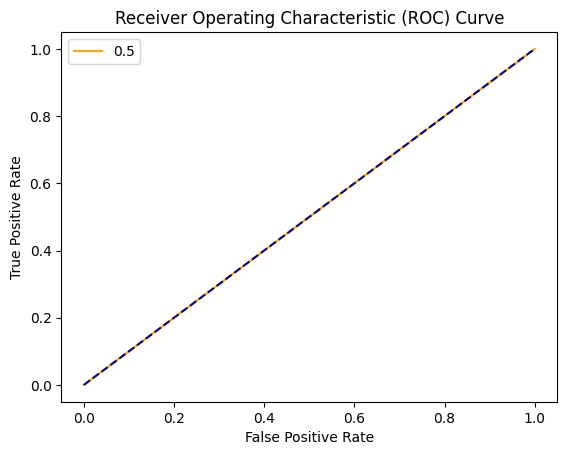

In [60]:
auc = roc_auc_score(y_test, y_pred)
print('AUC: %f' %auc)

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='orange', label=auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

filename = 'ROCcurve.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

Standard scaler better than 50/50 guesswork

Robust scaler worse than 50/50!

Min/Max scaler appalingly bad.

In [61]:
y_test

642    1
695    1
453    0
565    0
99     1
      ..
455    1
354    0
216    1
509    0
728    0
Name: Outcome, Length: 231, dtype: int64

In [62]:
y_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [63]:
## Can we get a df comparison this output???
df = pd.DataFrame({'Actual_value': y_test, 'Predicted_Value': y_pred.flatten()})
df




,Actual_value,Predicted_Value
642,1,1
695,1,1
453,0,1
565,0,1
99,1,1
...,...,...
455,1,1
354,0,1
216,1,1
509,0,1


In [64]:
## save the model
import time
myfile='diabetes-'+str(time.time())+'.keras'
keras.saving.save_model(model, myfile)

In [ ]:
# stick with the standard scaler and the model trained on it: diabetes-1740846975.210311.keras
ker_model=keras.models.load_model('diabetes-1740846975.210311.keras')

In [71]:
#ker_model.fit(x, y, batch_size = 25, epochs = 80, validation_split=0.25)
y_pred = ker_model.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [72]:
y_pred = np.where(y_pred > 0.4, 1, 0)
np.set_printoptions()

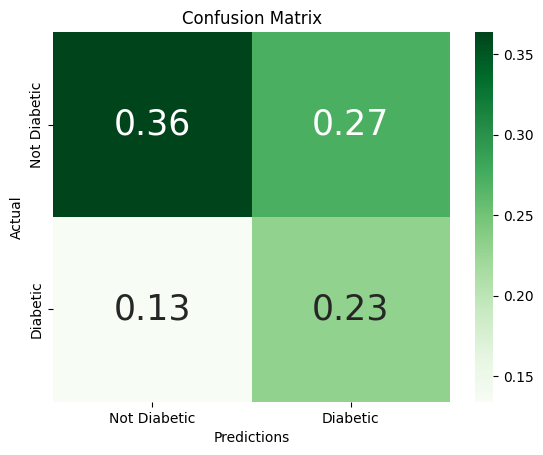

In [73]:
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Not Diabetic', 'Diabetic']
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, cmap='Greens',annot_kws = {'size':25}, xticklabels=labels, yticklabels=labels)
#sns.heatmap(cf_matrix, annot = True, cmap='Greens',annot_kws = {'size':25}, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

filename = 'ConfusionMatrix.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()